# **Data Preparation Notebook - China Air Quality Tabular**

## **Initial Steps**

### Import the required libraries

In [45]:
import os
import pandas as pd
import numpy as np
from pandas import concat, DataFrame, Series
from matplotlib.pyplot import show, figure, savefig, subplots
from utils.ds_charts import bar_chart, get_variable_types, multiple_bar_chart
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from numpy import nan

DATA_FOLDER = "data/"
DATA_PREP_FOLDER = DATA_FOLDER + "data-prep/"
DATA_FILE = DATA_FOLDER + "original_tabular.csv"
IMAGES_FOLDER = "images/"
DIMENSIONALITY_FOLDER = IMAGES_FOLDER + "missing-values/"
SCALING_FOLDER = IMAGES_FOLDER + "scaling/"
BALANCING_FOLDER = IMAGES_FOLDER + "balancing/"

if not os.path.exists(DATA_PREP_FOLDER):
    os.makedirs(DATA_PREP_FOLDER)

if not os.path.exists(DIMENSIONALITY_FOLDER):
    os.makedirs(DIMENSIONALITY_FOLDER)

if not os.path.exists(SCALING_FOLDER):
    os.makedirs(SCALING_FOLDER)
    
if not os.path.exists(BALANCING_FOLDER):
    os.makedirs(BALANCING_FOLDER)

df = pd.read_csv(DATA_FILE, parse_dates=["date"])

# We guessed that "Field_1" was the Air Quality Index value
df.rename(columns={'Field_1': 'AQI'}, inplace=True)

# Data cleaning on GbCity
df.loc[df["GbCity"] == "s", "GbCity"] = nan
df['GbCity'] = df["GbCity"].astype(np.float64)

### Remove unnecessary ID columns

In [46]:
df.drop(['FID'], axis=1, inplace=True)
df

,date,City_EN,Prov_EN,GbCity,GbProv,AQI,ALARM,CO_Mean,CO_Min,CO_Max,...,PM2.5_Max,PM2.5_Std,PM10_Mean,PM10_Min,PM10_Max,PM10_Std,SO2_Mean,SO2_Min,SO2_Max,SO2_Std
0,2020-01-01,Beijing,Beijing,1100.0,11,24.0,Safe,0.792917,0.60,1.09,...,48.0,7.618394,55.000000,38.0,86.0,14.044572,6.708333,3.0,12.0,2.440614
1,2020-01-01,Tianjin,Tianjin,1200.0,12,245.0,Safe,1.157083,0.71,1.46,...,78.0,12.203995,94.500000,64.0,123.0,17.327723,14.208333,9.0,20.0,3.054766
2,2020-01-01,Shijiazhuang,Hebei,1301.0,13,228.0,Safe,1.489167,1.17,1.94,...,95.0,13.515423,135.166667,114.0,168.0,15.249772,26.208333,22.0,33.0,2.676739
3,2020-01-01,Tangshan,Hebei,1302.0,13,244.0,Safe,1.882083,1.10,4.22,...,104.0,18.350324,133.458333,91.0,192.0,30.202068,35.208333,17.0,91.0,18.009209
4,2020-01-01,Qinhuangdao,Hebei,1303.0,13,201.0,Safe,1.389583,0.78,2.14,...,64.0,9.945686,74.416667,51.0,123.0,18.511070,25.416667,15.0,44.0,5.596998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169268,2021-03-24,Puer,Yunnan,530800.0,53,NaN,Safe,0.575000,0.40,0.90,...,48.0,13.438065,45.666667,6.0,87.0,27.025708,4.250000,3.0,20.0,3.319764
169269,2021-03-24,Zhongwei,Ningxia,640500.0,64,NaN,Danger,0.389583,0.15,0.90,...,73.0,11.246913,155.375000,118.0,241.0,36.133794,11.375000,5.0,23.0,5.368213
169270,2021-03-24,Kuerle,Xinjiang,652801.0,65,NaN,Safe,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169271,2021-03-24,Shihezi,Xinjiang,659001.0,65,NaN,Danger,0.639583,0.40,0.90,...,56.0,18.743703,154.083333,34.0,323.0,97.537137,7.208333,5.0,11.0,1.471370


## **Missing Values**

### Visualize missing values

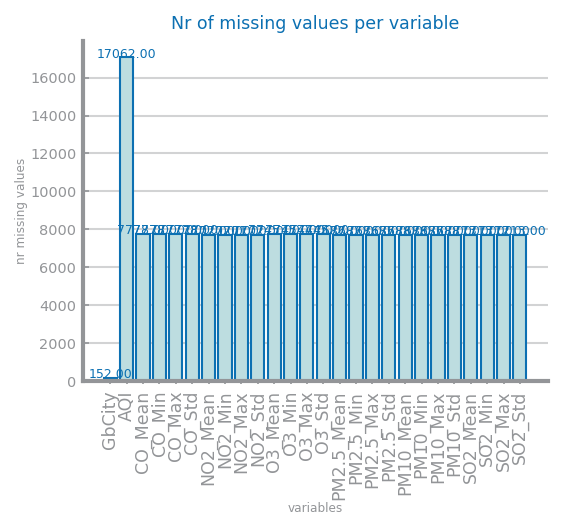

In [47]:
mv = {}
figure()
for var in df:
    nr = df[var].isna().sum()
    if nr > 0:
        mv[var] = nr

bar_chart(list(mv.keys()), list(mv.values()), title='Nr of missing values per variable', xlabel='variables', ylabel='nr missing values', rotation=True)

savefig(DIMENSIONALITY_FOLDER + '/missing_values_before.png')

show()

### Drop column if missing values > 85%

In [48]:
threshold = df.shape[0] * 0.85

missings = [c for c in mv.keys() if mv[c] > threshold]
df = df.drop(columns=missings, inplace=False)

print('Dropped variables', missings)

Dropped variables []


### Drop records if missing values > 50%

In [49]:
threshold = df.shape[1] * 0.50
df = df.dropna(thresh=threshold, inplace=False)

print(df.shape)

(161631, 31)


### Show missing values after these changes

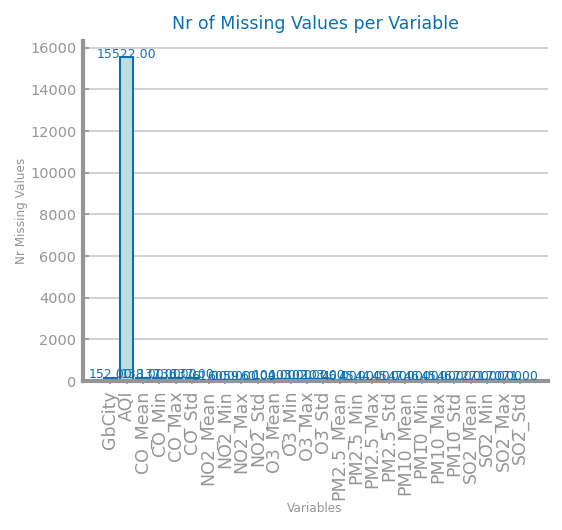

In [50]:
mv = {}
figure()
for var in df:
    nr = df[var].isna().sum()
    if nr > 0:
        mv[var] = nr
bar_chart(list(mv.keys()), list(mv.values()), title='Nr of Missing Values per Variable', xlabel='Variables', ylabel='Nr Missing Values', rotation=True)

savefig(DIMENSIONALITY_FOLDER + '/missing_values_after.png')

show()

### Impute other missing values

In [51]:
tmp_nr, tmp_sb, tmp_bool = None, None, None
variables = get_variable_types(df)
numeric_vars = variables['Numeric']
symbolic_vars = variables['Symbolic']
binary_vars = variables['Binary']

if len(numeric_vars) > 0:
    imp = SimpleImputer(strategy='mean', missing_values=nan, copy=True)
    tmp_nr = DataFrame(imp.fit_transform(df[numeric_vars]), columns=numeric_vars)
if len(symbolic_vars) > 0:
    imp = SimpleImputer(strategy='most_frequent', missing_values=nan, copy=True)
    tmp_sb = DataFrame(imp.fit_transform(df[symbolic_vars]), columns=symbolic_vars)
if len(binary_vars) > 0:
    imp = SimpleImputer(strategy='most_frequent', missing_values=nan, copy=True)
    tmp_bool = DataFrame(imp.fit_transform(df[binary_vars]), columns=binary_vars)

df = concat([tmp_nr, tmp_sb, tmp_bool], axis=1)

df.to_csv(f'{DATA_PREP_FOLDER}/drop_mv.csv', index=False)

df.describe(include='all')

,GbCity,GbProv,AQI,CO_Mean,CO_Min,CO_Max,CO_Std,NO2_Mean,NO2_Min,NO2_Max,...,PM10_Min,PM10_Max,PM10_Std,SO2_Mean,SO2_Min,SO2_Max,SO2_Std,City_EN,Prov_EN,ALARM
count,161631.000000,161631.000000,161631.000000,161631.000000,161631.000000,161631.000000,161631.000000,161631.000000,161631.000000,161631.000000,...,161631.000000,161631.000000,161631.000000,161631.000000,161631.000000,161631.000000,161631.000000,161631,161631,161631
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,361,31,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Taizhou,Shandong,Safe
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,898,12480,144663
mean,40469.155321,39.716713,170.225085,0.752409,0.529502,1.123513,0.166635,25.703129,13.071421,44.959455,...,37.643447,108.238486,20.043643,10.468338,6.388020,20.019479,3.657845,NaN,NaN,NaN
std,116949.872567,14.500042,93.165118,0.369636,0.246802,0.748969,0.206226,14.860565,9.715589,23.750248,...,43.961745,163.626081,43.479821,7.585699,3.584018,22.735621,5.512560,NaN,NaN,NaN
min,1100.000000,11.000000,1.000000,0.100000,0.100000,0.100000,0.000000,1.458333,1.000000,2.000000,...,1.000000,3.000000,0.000000,1.000000,1.000000,1.000000,0.000000,NaN,NaN,NaN
25%,3306.000000,32.000000,94.000000,0.529167,0.380000,0.710000,0.070788,14.666667,7.000000,26.000000,...,15.000000,52.000000,8.338733,6.000000,4.000000,8.000000,0.877971,NaN,NaN,NaN
50%,4303.000000,41.000000,170.225085,0.680000,0.500000,0.950000,0.115395,22.291667,10.000000,41.000000,...,28.000000,81.000000,13.339322,8.375000,6.000000,13.000000,1.914401,NaN,NaN,NaN
75%,5334.000000,51.000000,247.000000,0.879167,0.630000,1.300000,0.197855,33.541667,16.000000,60.000000,...,48.000000,124.500000,21.601645,12.375000,8.000000,23.000000,4.181432,NaN,NaN,NaN


### Remove outliers

In [52]:
# No outliers detected

### Agreggate symbolic variables in groups

In [53]:
# No new categories created

## **Dummification**

In [54]:
def dummify(df, vars_to_dummify):
    other_vars = [c for c in df.columns if not c in vars_to_dummify]
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=bool)
    X = df[vars_to_dummify]
    encoder.fit(X)
    new_vars = encoder.get_feature_names(vars_to_dummify)
    trans_X = encoder.transform(X)
    dummy = DataFrame(trans_X, columns=new_vars, index=X.index)
    dummy = dummy.convert_dtypes(convert_boolean=True)
    
    final_df = concat([df[other_vars], dummy], axis=1)
    return final_df

# No dummification needed, too many unique values for symbolic values

#### Transforming remaining Symbolic vars in Numeric vars

In [55]:
symbolic_vars = get_variable_types(df)['Symbolic']
if symbolic_vars:
    label_encoder = LabelEncoder()
    for var in symbolic_vars:
        df[var] = label_encoder.fit_transform(df[var])
        
df.to_csv(DATA_PREP_FOLDER + "dummification.csv", index=False)

df

,GbCity,GbProv,AQI,CO_Mean,CO_Min,CO_Max,CO_Std,NO2_Mean,NO2_Min,NO2_Max,...,PM10_Min,PM10_Max,PM10_Std,SO2_Mean,SO2_Min,SO2_Max,SO2_Std,City_EN,Prov_EN,ALARM
0,1100.0,11.0,24.000000,0.792917,0.60,1.09,0.103581,48.875000,36.0,62.0,...,38.0,86.0,14.044572,6.708333,3.0,12.0,2.440614,21,1,Safe
1,1200.0,12.0,245.000000,1.157083,0.71,1.46,0.211965,72.916667,64.0,88.0,...,64.0,123.0,17.327723,14.208333,9.0,20.0,3.054766,264,26,Safe
2,1301.0,13.0,228.000000,1.489167,1.17,1.94,0.191788,63.875000,52.0,80.0,...,114.0,168.0,15.249772,26.208333,22.0,33.0,2.676739,245,9,Safe
3,1302.0,13.0,244.000000,1.882083,1.10,4.22,0.793573,69.625000,60.0,90.0,...,91.0,192.0,30.202068,35.208333,17.0,91.0,18.009209,263,9,Safe
4,1303.0,13.0,201.000000,1.389583,0.78,2.14,0.407824,44.750000,23.0,66.0,...,51.0,123.0,18.511070,25.416667,15.0,44.0,5.596998,217,9,Safe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161626,451400.0,45.0,170.225085,0.804167,0.70,0.85,0.047690,20.000000,15.0,27.0,...,108.0,184.0,16.406247,18.666667,9.0,44.0,8.956686,45,6,Danger
161627,530800.0,53.0,170.225085,0.575000,0.40,0.90,0.093541,17.833333,12.0,39.0,...,6.0,87.0,27.025708,4.250000,3.0,20.0,3.319764,208,29,Safe
161628,640500.0,64.0,170.225085,0.389583,0.15,0.90,0.184266,29.250000,15.0,61.0,...,118.0,241.0,36.133794,11.375000,5.0,23.0,5.368213,350,19,Danger
161629,659001.0,65.0,170.225085,0.639583,0.40,0.90,0.148590,24.375000,12.0,51.0,...,34.0,323.0,97.537137,7.208333,5.0,11.0,1.471370,244,27,Danger


## **Scaling**

### Standard Scaler

In [56]:
variable_types = get_variable_types(df)
numeric_vars = variable_types['Numeric']
symbolic_vars = variable_types['Symbolic']
boolean_vars = variable_types['Binary']

df_nr = df[numeric_vars]
df_sb = df[symbolic_vars]
df_bool = df[boolean_vars]

transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=df.index, columns= numeric_vars)
norm_data_zscore = concat([tmp, df_sb,  df_bool], axis=1)

norm_data_zscore.to_csv(f'{DATA_PREP_FOLDER}/scaled_z_score.csv', index=False)

norm_data_zscore

,GbCity,GbProv,AQI,CO_Mean,CO_Min,CO_Max,CO_Std,NO2_Mean,NO2_Min,NO2_Max,...,PM10_Min,PM10_Max,PM10_Std,SO2_Mean,SO2_Min,SO2_Max,SO2_Std,City_EN,Prov_EN,ALARM
0,-0.336634,-1.980463,-1.569531e+00,0.109588,0.285648,-0.044745,-0.305755,1.559291,2.359986,0.717491,...,0.008111,-0.135911,-0.137974,-0.495672,-0.945316,-0.352729,-0.220811,-1.524816,-1.677662,Safe
1,-0.335779,-1.911498,8.026088e-01,1.094795,0.731352,0.449268,0.219805,3.177112,5.241961,1.812220,...,0.599536,0.090215,-0.062464,0.493034,0.728788,-0.000857,-0.109401,0.796320,1.211029,Safe
2,-0.334915,-1.842532,6.201365e-01,1.993205,2.595203,1.090151,0.121967,2.568677,4.006829,1.475381,...,1.736892,0.365233,-0.110255,2.074963,4.356013,0.570935,-0.177977,0.614832,-0.753281,Safe
3,-0.334907,-1.842532,7.918752e-01,3.056192,2.311573,4.134344,3.040060,2.955608,4.830250,1.896430,...,1.213708,0.511910,0.233636,3.261410,2.960926,3.122006,2.603402,0.786768,-0.753281,Safe
4,-0.334898,-1.842532,3.303276e-01,1.723795,1.014981,1.357186,1.169540,1.281710,1.021926,0.885911,...,0.303823,0.090215,-0.035248,1.970600,2.402892,1.054759,0.351771,0.347376,-0.753281,Safe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161626,3.513746,0.364365,6.101382e-16,0.140024,0.690833,-0.365187,-0.576775,-0.383777,0.198504,-0.756182,...,1.600409,0.463018,-0.083657,1.080765,0.728788,1.054759,0.961233,-1.295568,-1.099924,Danger
161627,4.192671,0.916089,6.101382e-16,-0.479958,-0.524722,-0.298428,-0.354437,-0.529577,-0.110279,-0.250923,...,-0.719797,-0.129799,0.160582,-0.819748,-0.945316,-0.000857,-0.061329,0.261408,1.557672,Safe
161628,5.130683,1.674710,6.101382e-16,-0.981580,-1.537685,-0.298428,0.085493,0.238677,0.198504,0.675386,...,1.827880,0.811374,0.370061,0.119523,-0.387282,0.131095,0.310268,1.617792,0.402195,Danger
161629,5.288879,1.743675,6.101382e-16,-0.305236,-0.524722,-0.298428,-0.087503,-0.089373,-0.110279,0.254337,...,-0.082878,1.312518,1.782292,-0.429758,-0.387282,-0.396713,-0.396636,0.605280,1.326577,Danger


### MinMax Scaler

In [57]:
transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=df.index, columns= numeric_vars)
norm_data_minmax = concat([tmp, df_sb,  df_bool], axis=1)

norm_data_minmax.to_csv(f'{DATA_PREP_FOLDER}/scaled_minmax.csv', index=False)

print(norm_data_minmax.describe())

              GbCity         GbProv            AQI        CO_Mean  \
count  161631.000000  161631.000000  161631.000000  161631.000000   
mean        0.059840       0.531791       0.500666       0.021682   
std         0.177761       0.268519       0.275636       0.012284   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.003353       0.388889       0.275148       0.014263   
50%         0.004868       0.555556       0.500666       0.019275   
75%         0.006436       0.740741       0.727811       0.025894   
max         1.000000       1.000000       1.000000       1.000000   

              CO_Min         CO_Max         CO_Std       NO2_Mean  \
count  161631.000000  161631.000000  161631.000000  161631.000000   
mean        0.120309       0.011385       0.003940       0.163816   
std         0.069132       0.008331       0.004876       0.100409   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.078431       0.0067

### Scaling Comparison

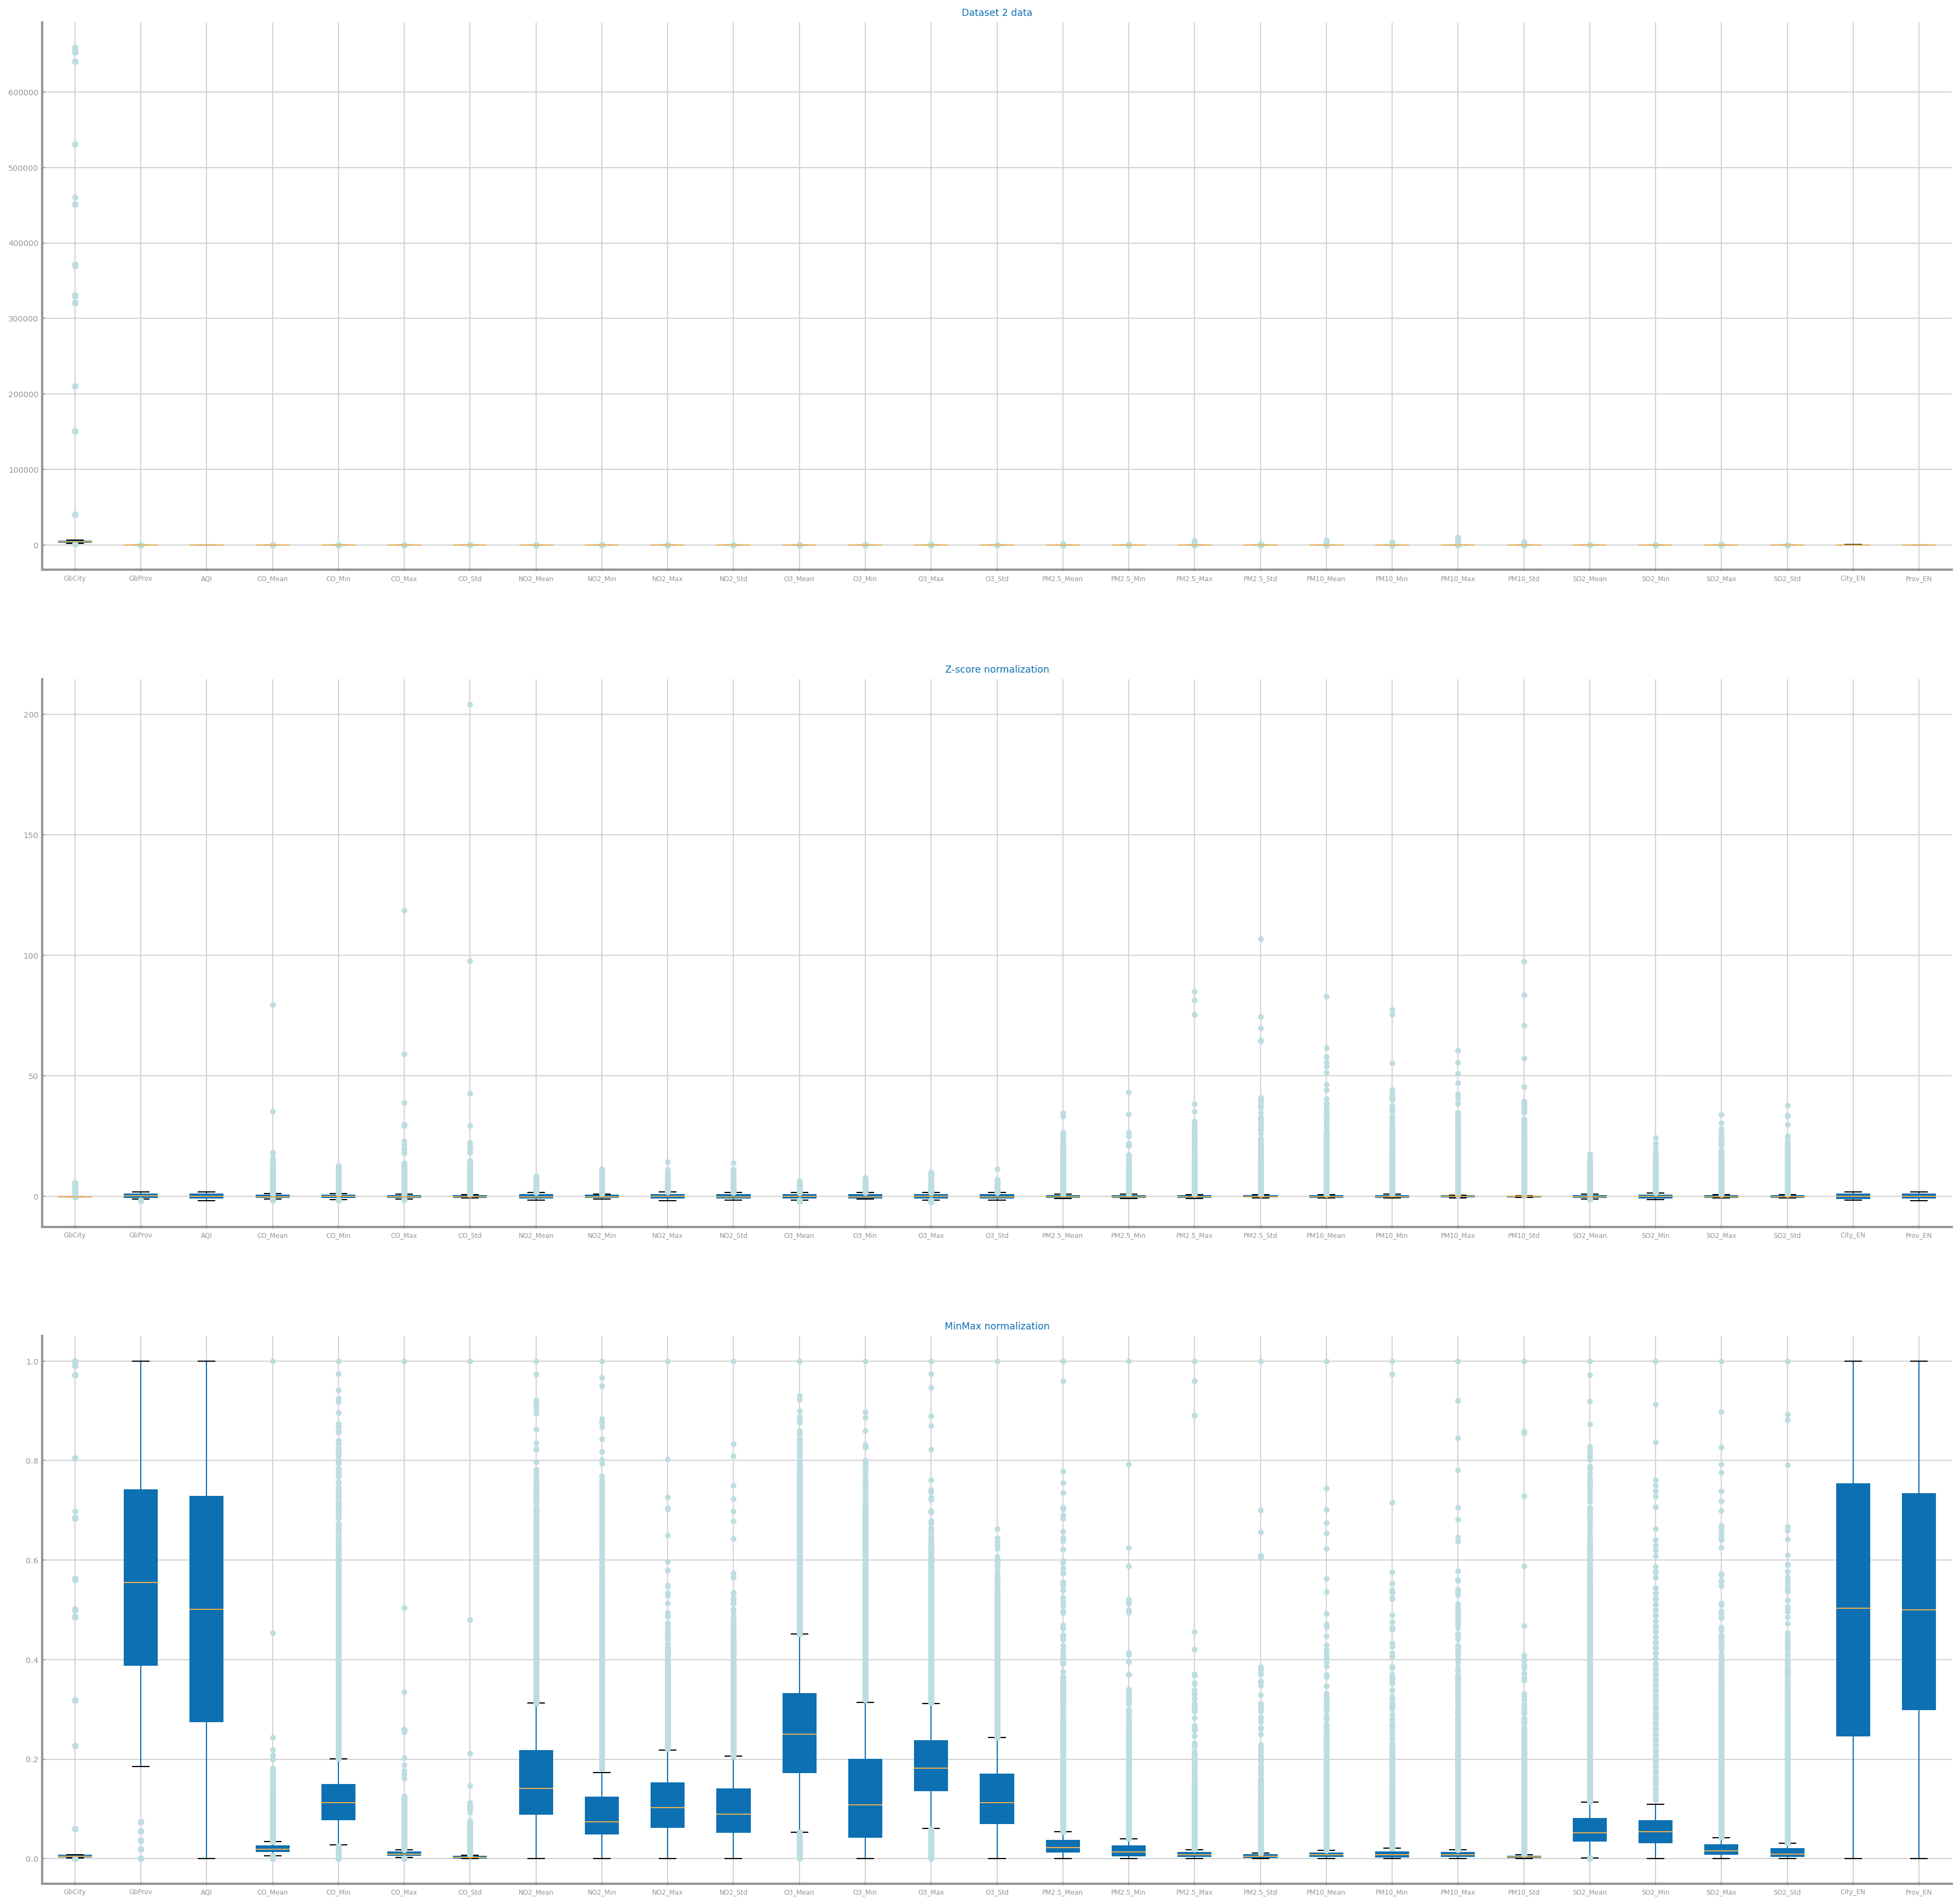

In [58]:
fig, axs = subplots(3, 1, figsize=(30,30),squeeze=False)

axs[0, 0].set_title('Dataset 2 data')
df.boxplot(ax=axs[0, 0])

axs[1, 0].set_title('Z-score normalization')
norm_data_zscore.boxplot(ax=axs[1, 0])

axs[2, 0].set_title('MinMax normalization')
norm_data_minmax.boxplot(ax=axs[2, 0])

savefig(SCALING_FOLDER + '/normalization.png')

show()

Based on the image above, we can observe that the Z-score normalization does not do a good job when there are outliers, so we will choose the MinMax normalizations.

In [59]:
df = norm_data_minmax
df

,GbCity,GbProv,AQI,CO_Mean,CO_Min,CO_Max,CO_Std,NO2_Mean,NO2_Min,NO2_Max,...,PM10_Min,PM10_Max,PM10_Std,SO2_Mean,SO2_Min,SO2_Max,SO2_Std,City_EN,Prov_EN,ALARM
0,0.000000,0.000000,0.068047,0.023028,0.140056,0.011012,0.002449,0.320383,0.289256,0.157895,...,0.010737,0.008315,0.003296,0.040342,0.021739,0.013924,0.011541,0.058333,0.033333,Safe
1,0.000152,0.018519,0.721893,0.035130,0.170868,0.015128,0.005012,0.482827,0.520661,0.226316,...,0.018282,0.012022,0.004066,0.093345,0.086957,0.024051,0.014445,0.733333,0.866667,Safe
2,0.000306,0.037037,0.671598,0.046166,0.299720,0.020467,0.004535,0.421734,0.421488,0.205263,...,0.032792,0.016530,0.003578,0.178151,0.228261,0.040506,0.012658,0.680556,0.300000,Safe
3,0.000307,0.037037,0.718935,0.059224,0.280112,0.045829,0.018764,0.460586,0.487603,0.231579,...,0.026117,0.018934,0.007087,0.241755,0.173913,0.113924,0.085163,0.730556,0.300000,Safe
4,0.000309,0.037037,0.591716,0.042857,0.190476,0.022692,0.009643,0.292511,0.181818,0.168421,...,0.014510,0.012022,0.004344,0.172556,0.152174,0.054430,0.026467,0.602778,0.300000,Safe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161626,0.684446,0.629630,0.500666,0.023402,0.168067,0.008343,0.001128,0.125282,0.115702,0.065789,...,0.031050,0.018133,0.003850,0.124853,0.086957,0.054430,0.042355,0.125000,0.200000,Danger
161627,0.805133,0.777778,0.500666,0.015786,0.084034,0.008899,0.002212,0.110642,0.090909,0.097368,...,0.001451,0.008415,0.006342,0.022968,0.021739,0.024051,0.015699,0.577778,0.966667,Safe
161628,0.971874,0.981481,0.500666,0.009624,0.014006,0.008899,0.004357,0.187782,0.115702,0.155263,...,0.033952,0.023843,0.008479,0.073322,0.043478,0.027848,0.025385,0.972222,0.633333,Danger
161629,0.999995,1.000000,0.500666,0.017932,0.084034,0.008899,0.003513,0.154842,0.090909,0.128947,...,0.009576,0.032058,0.022888,0.043875,0.043478,0.012658,0.006958,0.677778,0.900000,Danger


## **Data Balancing**

Minority (Positive) class= Danger : 16968
Majority (Negative) class= Safe : 144663
Proportion: 0.12 : 1


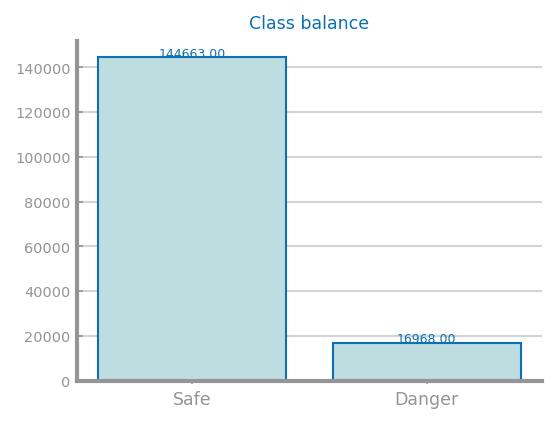

In [60]:
class_var = 'ALARM'

target_count = df[class_var].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

#ind_positive_class = target_count.index.get_loc(positive_class)
print('Minority (Positive) class=', positive_class, ':', target_count[positive_class])
print('Majority (Negative) class=', negative_class, ':', target_count[negative_class])
print('Proportion:', round(target_count[positive_class] / target_count[negative_class], 2), ': 1')
values = {'df': [target_count[positive_class], target_count[negative_class]]}

figure()
bar_chart(target_count.index, target_count.values, title='Class balance')

savefig(f'{BALANCING_FOLDER}/unbalanced_balance.png')

show()

In [61]:
df_positives = df[df[class_var] == positive_class]
df_negatives = df[df[class_var] == negative_class]

df_neg_sample = DataFrame(df_negatives.sample(len(df_positives)))
df_under = concat([df_positives, df_neg_sample], axis=0)

#df_under.to_csv(f'{DATA_PREP_FOLDER}/balance_under.csv', index=False)

values['UnderSample'] = [len(df_positives), len(df_neg_sample)]

print('Minority class=', positive_class, ':', len(df_positives))
print('Majority class=', negative_class, ':', len(df_neg_sample))
print('Proportion:', round(len(df_positives) / len(df_neg_sample), 2), ': 1')

Minority class= Danger : 16968
Majority class= Safe : 16968
Proportion: 1.0 : 1


In [62]:
df_pos_sample = DataFrame(df_positives.sample(len(df_negatives), replace=True))
df_over = concat([df_pos_sample, df_negatives], axis=0)

#df_under.to_csv(f'{DATA_PREP_FOLDER}/balance_over.csv', index=False)

values['OverSample'] = [len(df_pos_sample), len(df_negatives)]

print('Minority class=', positive_class, ':', len(df_pos_sample))
print('Majority class=', negative_class, ':', len(df_negatives))
print('Proportion:', round(len(df_pos_sample) / len(df_negatives), 2), ': 1')

Minority class= Danger : 144663
Majority class= Safe : 144663
Proportion: 1.0 : 1


#### SMOTE balancing

In [63]:
RANDOM_STATE = 42

df_copy = df.copy(deep=True)

print(df_copy["GbCity"].dtype)


smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)

y = df_copy.pop(class_var).values
X = df_copy.values

smote_X, smote_y = smote.fit_resample(X, y)
df_smote = concat([DataFrame(smote_X), DataFrame(smote_y)], axis=1)

df_smote.columns = list(df_copy.columns) + [class_var]

#df_smote.to_csv(f'{DATA_PREP_FOLDER}/balance_smote.csv', index=False)

smote_target_count = Series(smote_y).value_counts()

values['SMOTE'] = [smote_target_count[positive_class], smote_target_count[negative_class]]

print('Minority class=', positive_class, ':', smote_target_count[positive_class])
print('Majority class=', negative_class, ':', smote_target_count[negative_class])
print('Proportion:', round(smote_target_count[positive_class] / smote_target_count[negative_class], 2), ': 1')

float64
Minority class= Danger : 144663
Majority class= Safe : 144663
Proportion: 1.0 : 1


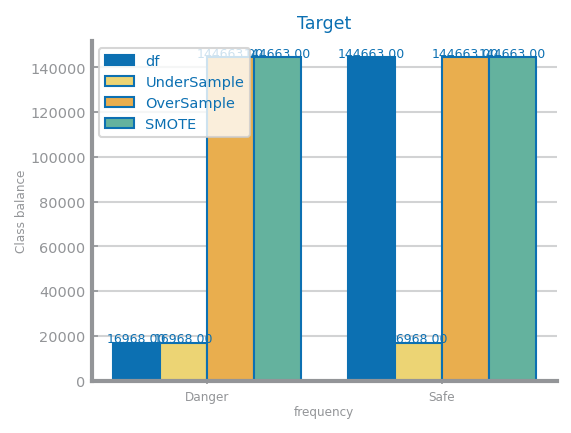

In [64]:
figure()
multiple_bar_chart([positive_class, negative_class], values, title='Target', xlabel='frequency', ylabel='Class balance')

savefig(f'{BALANCING_FOLDER}/balancing_strategies_comparison.png')

show()

## **Save the prepared dataset**

In [66]:
df.to_csv(DATA_FOLDER + "data_prep_final.csv", index=False)